In [ ]:
from google.colab import files
uploaded = files.upload()



Saving Dataset_nnminipro1_7.zip to Dataset_nnminipro1_7.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
zip_path = "/content/Dataset_nnminipro1_7.zip"
extract_path = "/content/Dataset_nnminipro1_7"
shutil.unpack_archive(zip_path, extract_path)

#  paths after unzipping
data_root = os.path.join(extract_path, "Dataset_nnminipro1_7")
train_path = os.path.join(data_root, "Train_7sp")
test_path = os.path.join(data_root, "Test_7sp")

print("Train path:", train_path)
print("Test path:", test_path)


Train path: /content/Dataset_nnminipro1_7/Dataset_nnminipro1_7/Train_7sp
Test path: /content/Dataset_nnminipro1_7/Dataset_nnminipro1_7/Test_7sp


Train set shape: (3288, 256, 256, 1)
Test set shape: (1266, 256, 256, 1)
Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step
Epoch 1: MSE=0.101140, MAE=0.210834, R²=0.363051, Acc(MSE)=0.8989, Acc(MAE)=0.7892
329/329 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - loss: 0.1371 - val_loss: 0.0757
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
Epoch 2: MSE=0.082047, MAE=0.156798, R²=0.483292, Acc(MSE)=0.9180, Acc(MAE)=0.8432
329/329 ━━━━━━━━━━━━━━━━━━━━ 61s 69ms/step - loss: 0.0959 - val_loss: 0.0604
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
Epoch 3: MSE=0.064954, MAE=0.138020, R²=0.590940, Acc(MSE)=0.9350, Acc(MAE)=0.8620
329/329 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - loss: 0.0758 - val_loss: 0.0470
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
Epoch 4: MSE=0.056065, MAE=0.117449, R²=0.646920, Acc(MSE)=0.9439, Acc(MAE)=0.8826
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - loss: 0.0615 - val_loss: 0.0400
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Epoch 5: MSE=0.051389

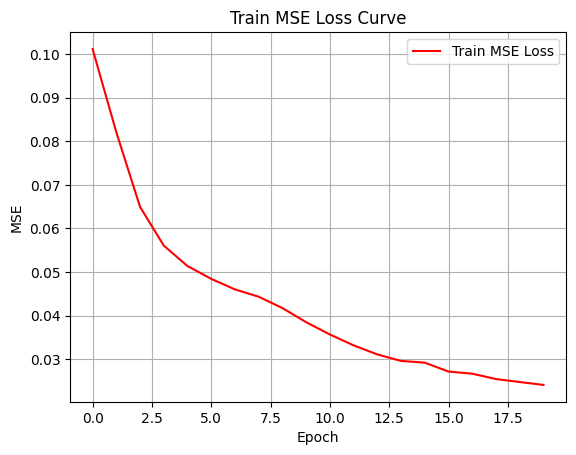

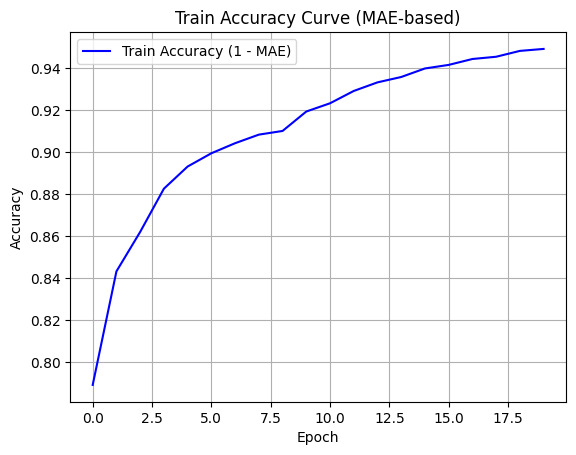

Model saved to: /content/drive/MyDrive/nnminipro1_7species/nnproject1_results/autoencoder_model_mbmu.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step


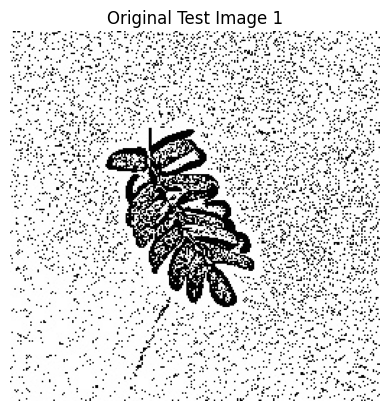

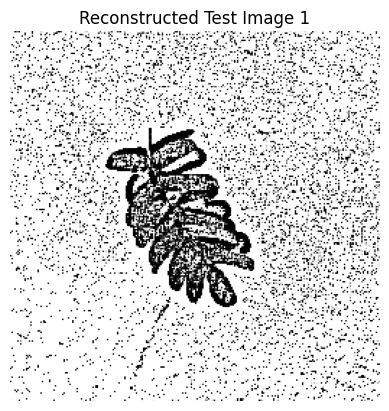

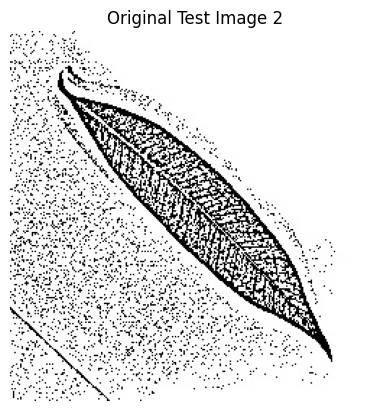

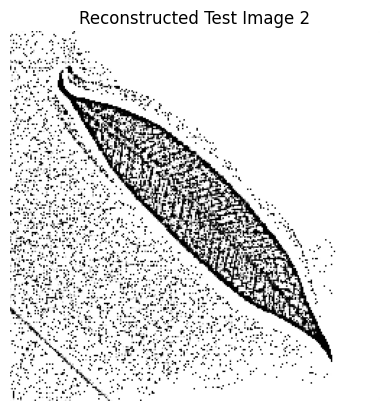

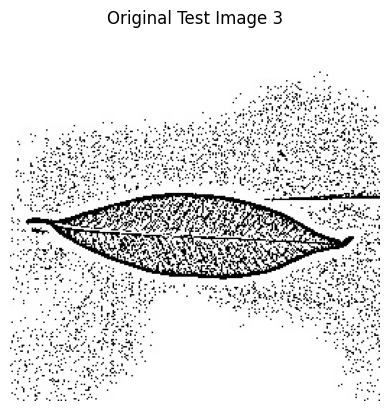

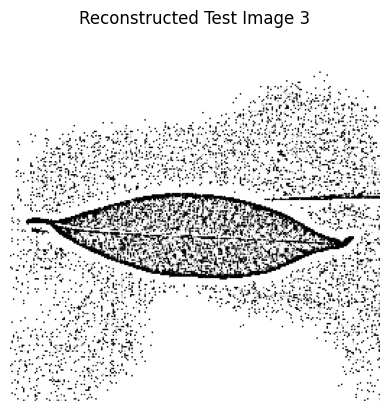

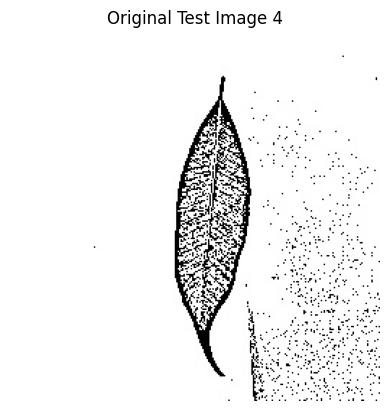

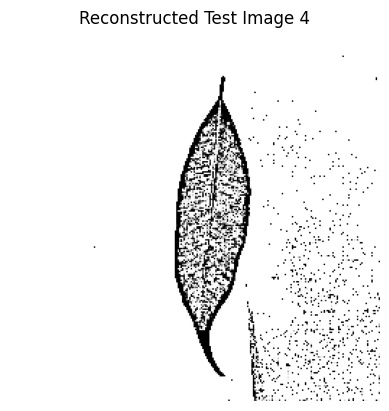

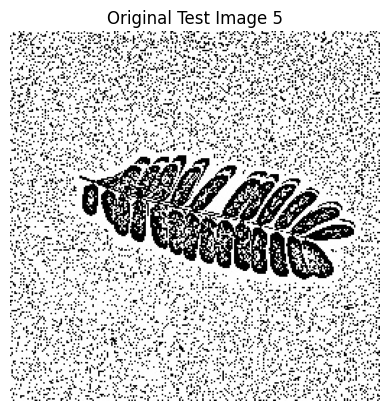

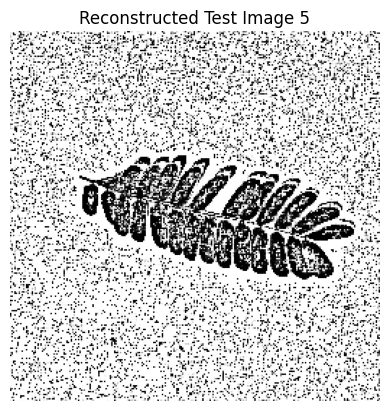

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

# === Load Images ===
def load_images_from_folder(folder_path):
    images = []
    for subfolder in sorted(os.listdir(folder_path)):
        subfolder_path = os.path.join(folder_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = img.astype("float32") / 255.0
                img = np.expand_dims(img, axis=-1)
                images.append(img)
    return np.array(images)

x_train = load_images_from_folder(train_path)
x_test = load_images_from_folder(test_path)

print("Train set shape:", x_train.shape)
print("Test set shape:", x_test.shape)

# Define Autoencoder
input_img = Input(shape=(256, 256, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')

#  Custom Metrics Logger
train_mse_list = []
train_mae_list = []

class MetricsLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(x_train)
        mse = mean_squared_error(x_train.flatten(), preds.flatten())
        mae = mean_absolute_error(x_train.flatten(), preds.flatten())
        r2 = r2_score(x_train.flatten(), preds.flatten())
        acc_mse = 1 - mse
        acc_mae = 1 - mae
        train_mse_list.append(mse)
        train_mae_list.append(acc_mae)
        print(f"Epoch {epoch+1}: MSE={mse:.6f}, MAE={mae:.6f}, R²={r2:.6f}, Acc(MSE)={acc_mse:.4f}, Acc(MAE)={acc_mae:.4f}")

#  Train Model
history = autoencoder.fit(x_train, x_train,
                          epochs=20,
                          batch_size=10,
                          shuffle=True,
                          callbacks=[MetricsLogger()],
                          validation_data=(x_test, x_test))

#  Evaluate on Test
decoded_test = autoencoder.predict(x_test)
test_mse = mean_squared_error(x_test.flatten(), decoded_test.flatten())
test_mae = mean_absolute_error(x_test.flatten(), decoded_test.flatten())
test_r2 = r2_score(x_test.flatten(), decoded_test.flatten())

print(f"\nTest MSE: {test_mse:.6f}")
print(f"Test MAE: {test_mae:.6f}")
print(f"Test R² Score: {test_r2:.6f}")

#  Save plots to Google Drive
drive_path = "/content/drive/MyDrive/nnminipro1_7species/nnproject1_results"
os.makedirs(drive_path, exist_ok=True)

# MSE Curve
plt.plot(train_mse_list, label='Train MSE Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Train MSE Loss Curve")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(drive_path, "train_mse_loss_curve.png"))
plt.show()

# Accuracy Curve
plt.plot(train_mae_list, label='Train Accuracy (1 - MAE)', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train Accuracy Curve (MAE-based)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(drive_path, "train_accuracy_mae_curve.png"))
plt.show()

#  Save Model
model_path = os.path.join(drive_path, "autoencoder_model_mbmu.h5")
autoencoder.save(model_path)
print(f"Model saved to: {model_path}")

#  Visualize & Save 5 Random Test Reconstructions
random_indices = random.sample(range(len(x_test)), 5)
decoded_random = autoencoder.predict(x_test[random_indices])

for i, idx in enumerate(random_indices):
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    plt.title(f"Original Test Image {i+1}")
    plt.axis("off")
    plt.savefig(os.path.join(drive_path, f"Original_Test_Image_{i+1}.png"))
    plt.show()

    plt.imshow(decoded_random[i].squeeze(), cmap='gray')
    plt.title(f"Reconstructed Test Image {i+1}")
    plt.axis("off")
    plt.savefig(os.path.join(drive_path, f"Reconstructed_Test_Image_{i+1}.png"))
    plt.show()
